# Prostate Cancer Data Set  
**Math 280 – UC Merced (Spring 280)**

This data set is a classic example used throughout *The Elements of Statistical Learning* (ESL) and will serve as a running example for least-squares regression and related methods in Math 280.

In class, we will use this data to:
- Explore linear regression and least-squares estimation
- Discuss training vs. test sets
- Examine feature scaling and its role in regression
- Reproduce and interpret results from ESL

## Data Description

The data consist of measurements from men who were about to receive a radical prostatectomy. The goal is to predict prostate-specific antigen levels using clinical predictors.

### Predictors (Columns 1–8)

| Variable | Description |
|--------|-------------|
| `lcavol` | Log cancer volume |
| `lweight` | Log prostate weight |
| `age` | Age |
| `lbph` | Log benign prostatic hyperplasia amount |
| `svi` | Seminal vesicle invasion (0/1 indicator) |
| `lcp` | Log capsular penetration |
| `gleason` | Gleason score |
| `pgg45` | Percentage Gleason scores 4 or 5 |

### Outcome (Column 9)

- `lpsa` — Log prostate-specific antigen

### Train/Test Indicator (Column 10)

The final column indicates whether an observation belongs to the **training set** or the **test set**:
- 67 observations are used for training
- 30 observations are reserved for testing  

This split follows the description in ESL (see page 48).

## Notes on Data Quality

An error appeared in the **first edition** of ESL:
- Subject 32 had an incorrect value of `lweight = 6.1`, corresponding to an implausible prostate weight.
- The corrected value is `44.9` grams.

We use the **corrected version** of the data in this repository.

## Feature Scaling (Math Version)

Before reproducing results from ESL (Tables 3.1 and onward), we standardize the predictors to make computations well-behaved and comparable across features.

Let 

$$
X \in \mathbb{R}^{n \times p}, \quad n = 96, \quad p = 8
$$

be the design matrix:

- **Rows** = observations (patients)  
- **Columns** = features (predictors)


### Column-wise Standardization (Z-scoring)

For each column \(j = 1, \dots, p\), we compute:

$$
\bar{x}_j = \frac{1}{n} \sum_{i=1}^n x_{ij}, 
\qquad
s_j^2 = \frac{1}{n-1} \sum_{i=1}^n (x_{ij} - \bar{x}_j)^2
$$

and define the standardized feature:

$$
X^*_{ij} = \frac{x_{ij} - \bar{x}_j}{s_j}
$$

After this scaling:

$$
\frac{1}{n-1} \sum_{i=1}^n (x^*_{ij})^2 = 1, 
\qquad \sum_{i=1}^n x^*_{ij} = 0
$$

so each column has **mean zero** and **unit variance**.


### Key Takeaways

1. We **scale features (columns)**, not observations (rows).  
2. Standardization ensures each column has **mean 0** and variance 1.  
3. Sum-of-squares statements like “equals 96” are just a normalization convention; the essential property is **unit-variance columns**.  

This standardized matrix `X^*` is what we will use for least-squares regression and all subsequent examples in this notebook.


## Load Libraries and Look at Raw Data

In this section, we import the necessary Python libraries and take an initial look at the raw prostate dataset.

- **pandas (`pd`)**: For reading and manipulating tabular data  
- **seaborn (`sns`)**: For plotting, including scatterplot matrices  
- **matplotlib (`plt`)**: For customizing plots and displaying them

We then read in the dataset and inspect the first few rows to understand its structure:

- Rows = observations (patients)  
- Columns = features (predictors and outcome)  

In [21]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook", font_scale=3)  

In [19]:
df = pd.read_csv('../../Data/prostate/prostate.data', delimiter='\t', index_col=0)
df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


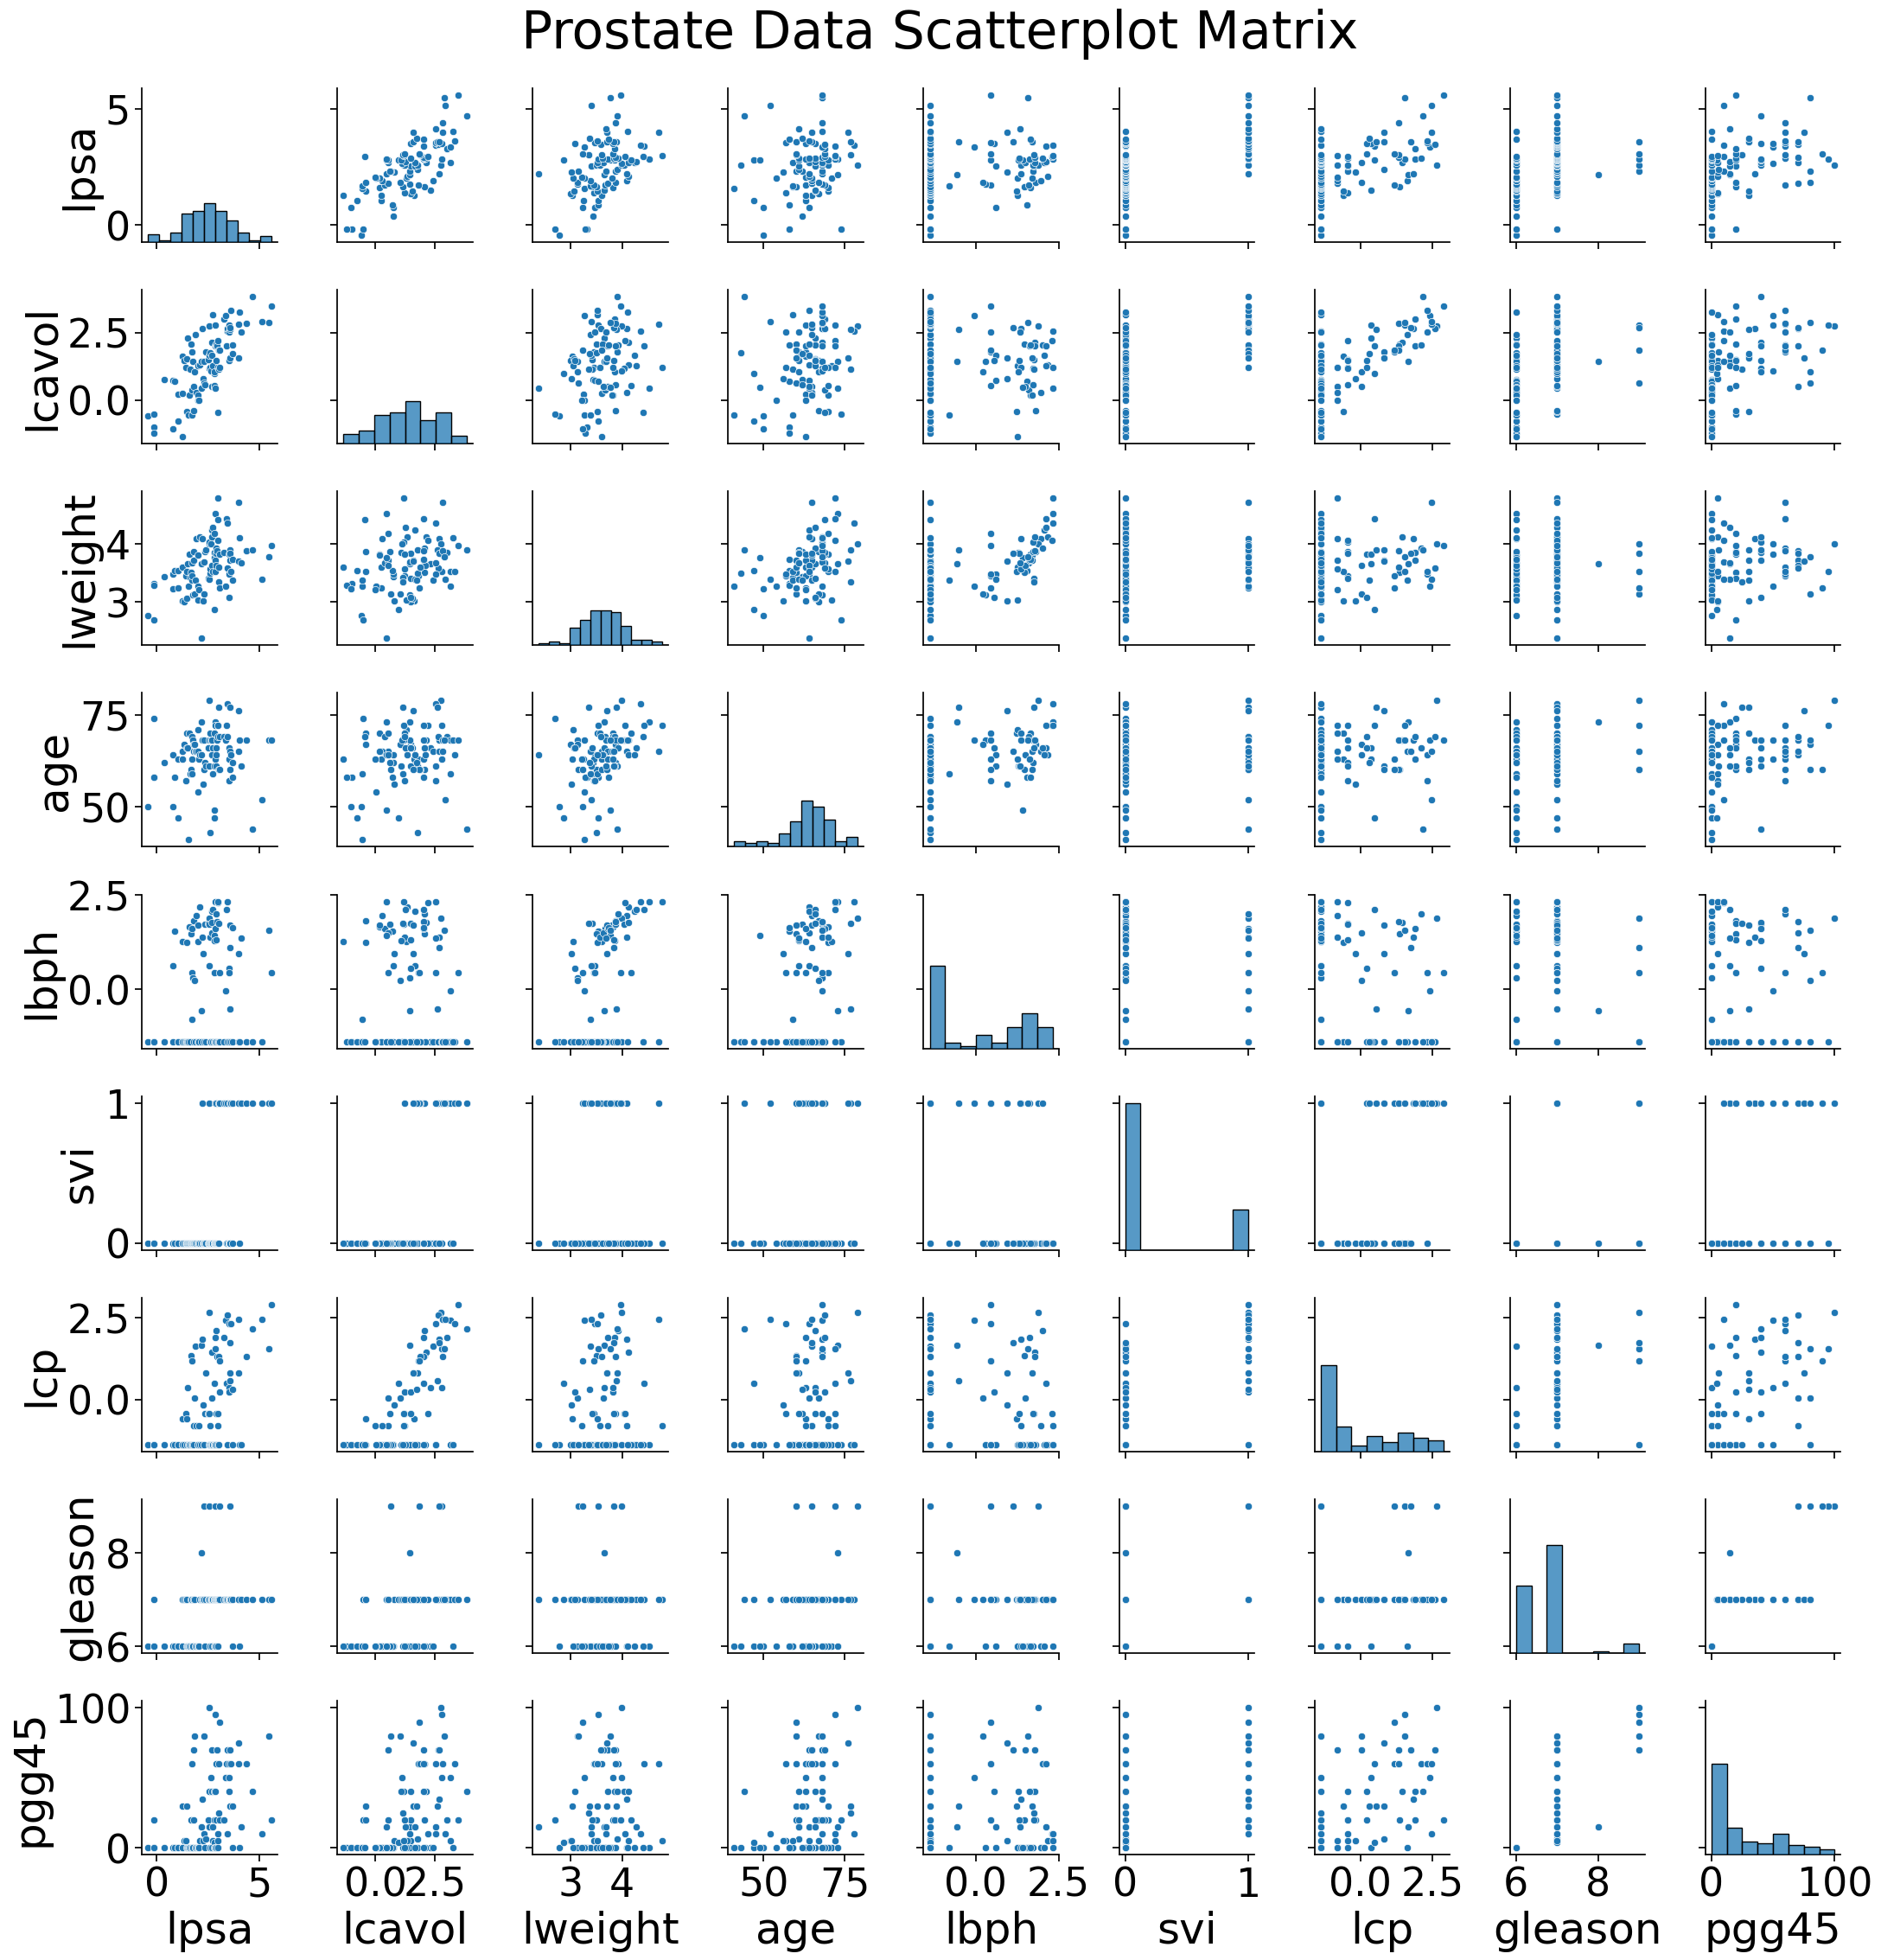

In [22]:
# Select the 9 features (8 predictors + outcome)
cols_to_plot = ['lpsa','lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45',]
df_plot = df[cols_to_plot]

# Scatterplot matrix
sns.pairplot(df_plot, diag_kind='hist')
plt.suptitle("Prostate Data Scatterplot Matrix", y=1.02)
plt.show()

## Data Cleaning: Extracting Key Columns

In our dataset, not all columns are predictors. Two columns have a special role:

1. **`train`** – indicates whether a row (patient) belongs to the training set  
2. **`lpsa`** – the outcome variable we want to predict

We will use **pandas `.pop()`** to remove these columns from the main DataFrame while storing them separately:

```python
mask_train = df.pop('train')
df_y = df.pop('lpsa')
df.head()

In [23]:
#Let's do a little data-cleaning by "pop"-ing out two columns
mask_train = df.pop('train')
df_y = df.pop('lpsa')
df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0


In [2]:
# Table 3.1. Correlations of predictors in the prostate cancer data
df[mask_train == 'T'].corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000


In [3]:
""" TABLE 3.2. Linear model fit to the prostate cancer data. The Z score is the
coefficient divided by its standard error (3.12). Roughly a Z score larger than two
in absolute value is significantly nonzero at the p = 0.05 level.
"""
class LinearRegression:
    def fit(self, X, y):
        X = np.c_[np.ones((X.shape[0], 1)), X]
        XX_inv = np.linalg.inv(X.T @ X)
        self.beta = XX_inv @ X.T @ y
        
        var = np.sum((X @ self.beta - y)**2) / (X.shape[0] - X.shape[1])
        self.stderr = np.sqrt(np.diag(XX_inv * var))
        self.z_score = self.beta / self.stderr

        return self
        
    def predict(self, X):
        X = np.c_[np.ones((X.shape[0], 1)), X]
        return X @ self.beta
    
df = df.apply(stats.zscore)
train_x = df[mask_train == 'T']
train_y = df_y[mask_train == 'T']

model = LinearRegression().fit(train_x.values, train_y.values)

pd.DataFrame(data = {'Coefficient': model.beta, 
                     'Std. Error': model.stderr,
                     'Z Score' : model.z_score}, 
             index = ["Intercept", *df.columns.tolist()])

,Coefficient,Std. Error,Z Score
Intercept,2.464933,0.089315,27.598203
lcavol,0.676016,0.125975,5.366290
lweight,0.261694,0.095134,2.750789
age,-0.140734,0.100819,-1.395909
lbph,0.209061,0.101691,2.055846
svi,0.303623,0.122962,2.469255
lcp,-0.287002,0.153731,-1.866913
gleason,-0.021195,0.144497,-0.146681
pgg45,0.265576,0.152820,1.737840


In [4]:
rss1 = sum((model.predict(train_x.values) - train_y) ** 2)

train_x_hyp = train_x.drop(columns = ['age', 'lcp', 'gleason', 'pgg45'])
model_hyp = LinearRegression().fit(train_x_hyp.values, train_y.values)

rss0 = sum((model_hyp.predict(train_x_hyp) - train_y) ** 2)

dfn = train_x.shape[1] - train_x_hyp.shape[1]
dfd = train_x.shape[0] - train_x.shape[1] - 1
f_stats = ((rss0 - rss1) / dfn) / (rss1 / dfd)
prob = 1 - stats.f.cdf(f_stats, dfn = dfn, dfd = dfd)

print ('RSS1 = ', rss1)
print ('RSS0 = ', rss0)
print ('F =', f_stats)
print (f'Pr(F({dfn}, {dfd}) > {f_stats:.2f}) = {prob:.2f}')

RSS1 =  29.426384459908395
RSS0 =  32.81499474881555
F = 1.6697548846375236
Pr(F(4, 58) > 1.67) = 0.17


In [5]:
test_x = df[mask_train == 'F']
test_y = df_y[mask_train == 'F']

test_error = np.mean((test_y - model.predict(test_x)) ** 2)
base_error = np.mean((test_y - np.mean(train_y)) ** 2)
print ('Prediction error: ', test_error)
print ('Base error rate: ', base_error)

Prediction error:  0.5212740055076007
Base error rate:  1.0567332280603818
